[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/streaming-interruption.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239464-lesson-1-streaming)

# Streaming

## Review

In module 2, covered a few ways to customize graph state and memory.
 
We built up to a Chatbot with external memory that can sustain long-running conversations. 

## Goals

This module will dive into `human-in-the-loop`, which builds on memory and allows users to interact directly with graphs in various ways. 

To set the stage for `human-in-the-loop`, we'll first dive into streaming, which provides several ways to visualize graph output (e.g., node state or chat model tokens) over the course of execution.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

## Streaming

LangGraph is built with [first class support for streaming](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

Let's set up our Chatbot from Module 2, and show various way to stream outputs from the graph during execution. 

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Note that we use `RunnableConfig` with `call_model` to enable token-wise streaming. This is [only needed with python < 3.11](https://langchain-ai.github.io/langgraph/how-tos/streaming-tokens/). We include in case you are running this notebook in CoLab, which will use python 3.x. 

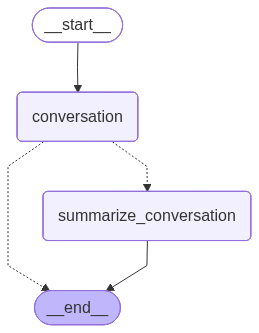


 Graph Statistics:
   - Total nodes: 4
   - Total edges: 4


In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import Literal
from IPython.display import Image, display

# Initialize the LLM with streaming enabled
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    streaming=True  # Enable streaming at model level
)

# Define state with additional metadata
class State(MessagesState):
    summary: str
    message_count: int = 0  # Track number of messages
    
# Define the logic to call the model
def call_model(state: State):
    summary = state.get("summary", "")
    
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = llm.invoke(messages)
    
    # Update message count
    new_count = state.get("message_count", 0) + 1
    
    return {
        "messages": response,
        "message_count": new_count
    }
    
def summarize_conversation(state: State):
    summary = state.get("summary", "")
    
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\\n\\n"
            "Extend the summary by taking into account the new messages above:"
        )
    else:
        summary_message = "Create a summary of the conversation above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    """Return the next node to execute."""
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    return END

# Build the graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile with memory
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Print graph statistics
print(f"\n Graph Statistics:")
print(f"   - Total nodes: {len(graph.get_graph().nodes)}")
print(f"   - Total edges: {len(list(graph.get_graph().edges))}")

### Streaming full state

Now, let's talk about ways to [stream our graph state](https://langchain-ai.github.io/langgraph/concepts/low_level/#streaming).

`.stream` and `.astream` are sync and async methods for streaming back results. 
 
LangGraph supports a few [different streaming modes](https://langchain-ai.github.io/langgraph/how-tos/stream-values/) for [graph state](https://langchain-ai.github.io/langgraph/how-tos/stream-values/):
 
* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [8]:
# Create a thread with metadata
config = {
    "configurable": {
        "thread_id": "1",
        "user_id": "riya", 
    }
}

# Start conversation with timing
import time
start_time = time.time()

for chunk in graph.stream(
    {"messages": [HumanMessage(content="hi! I'm Riya")]}, 
    config, 
    stream_mode="updates"
):
    print(chunk)

elapsed = time.time() - start_time
print(f"\n  Response time: {elapsed:} seconds")

{'conversation': {'messages': AIMessage(content="Hi Riya! It's nice to meet you. How can I help you today?\n", additional_kwargs={}, response_metadata={'safety_ratings': [], 'grounding_metadata': {}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'model_provider': 'google_genai'}, id='lc_run--28ec8d68-c6a1-4427-a2d1-8084d15f4df7', usage_metadata={'input_tokens': 7, 'output_tokens': 20, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}}), 'message_count': 1}}

  Response time: 1.6097137928009033 seconds


Let's now just print the state update.

In [9]:
for chunk in graph.stream(
    {"messages": [HumanMessage(content="hi! I'm Riya")]}, 
    config, 
    stream_mode="updates"
):
    if "conversation" in chunk:
        chunk['conversation']["messages"].pretty_print()
        
        # Show token usage
        if hasattr(chunk['conversation']["messages"], 'usage_metadata'):
            usage = chunk['conversation']["messages"].usage_metadata
            print(f"Tokens - Input: {usage.get('input_tokens', 0)}, "
                  f"Output: {usage.get('output_tokens', 0)}")

================================== Ai Message ==================================

Hi Riya! It's nice to meet you. What can I do for you today?
Tokens - Input: 34, Output: 21


Now, we can see `stream_mode="values"`.

This is the `full state` of the graph after the `conversation` node is called.

In [15]:
# Start conversation with a new thread
config = {
    "configurable": {
        "thread_id": "2",
        "user_id": "riya",
    }
}

input_message = HumanMessage(content="hi! I'm Riya")
for event in graph.stream(
    {"messages": [input_message]}, 
    config, 
    stream_mode="values"
):
    for m in event['messages']:
        role = "Riya" if m.type == "human" else "BookBot"
        print(f"\n{role}:")
        m.pretty_print()
    
    # Show state metadata
    if 'message_count' in event:
        print(f"\n Message Count: {event['message_count']}")
    


Riya:
================================ Human Message =================================

hi! I'm Riya

BookBot:
================================== Ai Message ==================================

Hi Riya! It's nice to meet you. How can I help you today?

Riya:
================================ Human Message =================================

hi! I'm Riya

BookBot:
================================== Ai Message ==================================

Hi Riya! It's nice to meet you. How can I help you today?

Riya:
================================ Human Message =================================

hi! I'm Riya

BookBot:
================================== Ai Message ==================================

Hi Riya! It's nice to meet you. What can I do for you today?

Riya:
================================ Human Message =================================

hi! I'm Riya

 Message Count: 3

Riya:
================================ Human Message =================================

hi! I'm Riya

BookBot:
========

### Streaming tokens

We often want to stream more than graph state.

In particular, with chat model calls it is common to stream the tokens as they are generated.

We can do this [using the `.astream_events` method](https://langchain-ai.github.io/langgraph/how-tos/streaming-from-final-node/#stream-outputs-from-the-final-node), which streams back events as they happen inside nodes!

Each event is a dict with a few keys:
 
* `event`: This is the type of event that is being emitted. 
* `name`: This is the name of event.
* `data`: This is the data associated with the event.
* `metadata`: Contains`langgraph_node`, the node emitting the event.

Let's have a look.

In [17]:
config = {"configurable": {"thread_id": "3", "user_id": "riya"}}
input_message = HumanMessage(content="Tell me about the major characters in the book the lies of locke lamora.")

event_counts = {}

async for event in graph.astream_events(
    {"messages": [input_message]}, 
    config, 
    version="v2"
):
    event_type = event['event']
    event_counts[event_type] = event_counts.get(event_type, 0) + 1
    
    node = event['metadata'].get('langgraph_node', 'root')
    name = event.get('name', 'unknown')
    
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

for event_type, count in sorted(event_counts.items()):
    print(f"   {event_type:30}: {count:4} occurrences")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream. Name: ChatGoogleGenerativeAI
Node: conversation. Type: on_chat_model_stream.

The central point is that tokens from chat models within your graph have the `on_chat_model_stream` type.

We can use `event['metadata']['langgraph_node']` to select the node to stream from.

And we can use `event['data']` to get the actual data for each event, which in this case is an `AIMessageChunk`. 

In [25]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the main characters in the book The Lies of Locke Lamora")
token_count = 0

async for event in graph.astream_events(
    {"messages": [input_message]}, 
    config, 
    version="v2"
):
    if (event["event"] == "on_chat_model_stream" and 
        event['metadata'].get('langgraph_node','') ==node_to_stream):
        token_count += 1
        print(event["data"])

print(f"\n Total token chunks streamed: {token_count}")

{'chunk': AIMessageChunk(content='Okay', additional_kwargs={}, response_metadata={'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--f1a085ab-3d2e-439d-8eb9-6de4828ec012', usage_metadata={'input_tokens': 1205, 'output_tokens': 0, 'total_tokens': 1205, 'input_token_details': {'cache_read': 0}})}
{'chunk': AIMessageChunk(content=", let'", additional_kwargs={}, response_metadata={'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--f1a085ab-3d2e-439d-8eb9-6de4828ec012', usage_metadata={'input_token_details': {'cache_read': 0}, 'output_tokens': 0, 'total_tokens': 0, 'input_tokens': 0})}
{'chunk': AIMessageChunk(content='s break down the main characters in Scott Lynch\'s "The Lies of Locke', additional_kwargs={}, response_metadata={'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--f1a085ab-3d2e-439d-8eb9-6de4828ec012', usage_metadata={'input_token_details': {'ca

As you see above, just use the `chunk` key to get the `AIMessageChunk`.

In [23]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the major characters in the lies of locke lamora")

accumulated_content = ""
token_count = 0

async for event in graph.astream_events(
    {"messages": [input_message]}, 
    config, 
    version="v2"
):
    if (event["event"] == "on_chat_model_stream" and 
        event['metadata'].get('langgraph_node','') == node_to_stream):
        data = event["data"]
        content = data["chunk"].content
        accumulated_content += content
        token_count += 1
        print(content, end="|", flush=True)

print(f"   - Total tokens: {token_count}")
print(f"   - Total characters: {len(accumulated_content)}")
print(f"   - Average chars/token: {len(accumulated_content)/token_count:.2f}")

Okay|, let'|s dive into the major characters of Scott Lynch's *The Lies of Locke| Lamora*. I'll cover their roles, personalities, and significant relationships:

The Gentleman Bastards:**

 and exceptionally clever thief and con artist. He's known for his elaborate schemes, his love of fine things, and his deep loyalty to his friends. He|'s also plagued by self-doubt and a fear of failure, despite his outward confidence. Locke is the strategist and the face of the group. He's not a fighter, but he's a master of deception and manipulation.| He's driven by a desire for a better life for himself and his friends, and a love of the game.

 a skilled swordsman, a scholar, and the moral compass of the group. He's more pragmatic and cautious than Locke, often acting as a voice of reason. He's fiercely loyal to Locke and the others, and he's willing to do whatever it takes to protect them. Jean is also secretly a| romantic and has a deep love for books and learning. He provides a grounding infl

In [28]:
# Compare streaming modes side by side
async def compare_streaming_modes(input_msg):
    """Compare different streaming modes."""
    
    print(" Streaming Mode Comparison\n")
    print("="*60)
    
    modes = ["values", "updates"]
    results = {}
    
    for mode in modes:
        print(f"\n Mode: {mode}")
        print("-" * 40)
        
        config = {"configurable": {"thread_id": f"compare_{mode}"}}
        start_time = time.time()
        event_count = 0
        
        for event in graph.stream(
            {"messages": [input_msg]},
            config,
            stream_mode=mode
        ):
            event_count += 1
        
        elapsed = time.time() - start_time
        results[mode] = {
            "events": event_count,
            "time": elapsed
        }
        
        print(f"Events: {event_count}, Time: {elapsed:.3f}s")
    
    print("\n" + "="*60)
    print(" Comparison Summary:")
    for mode, stats in results.items():
        print(f"   {mode:10}: {stats['events']} events in {stats['time']:.3f}s")

# Run comparison
await compare_streaming_modes(HumanMessage(content="Who are the major characters in the book the stormlight archive? what are the major themes?"))

 Streaming Mode Comparison


 Mode: values
----------------------------------------
Events: 2, Time: 11.010s

 Mode: updates
----------------------------------------
Events: 1, Time: 10.685s

 Comparison Summary:
   values    : 2 events in 11.010s
   updates   : 1 events in 10.685s


### Streaming with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

The LangGraph API [supports editing graph state](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation). 

In [10]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [29]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

Let's [stream `values`](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_values/), like before.

In [31]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="streaming", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019a260b-545b-737e-9418-039a8e604014', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '6e679f4e-e170-4721-8f44-7d6212abe762'}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '6e679f4e-e170-4721-8f44-7d6212abe762'}, {'content': '2 multiplied by 3 is 6.\n', 'additional_kwargs': {}, 'response_metadata': {'safety_ratings': [], 'grounding_metadata': {}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'model_provider': 'google_genai'}, 'type': 'ai', 'name': None, 'id': 'lc_run--40a1c3f8-9425-4ea9-a21e-6005df4744c9', 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 6, 'output_tokens': 10, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}}}], 'messa

The streamed objects have: 

* `event`: Type
* `data`: State

In [33]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="streaming", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='50ccf930-74ee-4e49-a87e-73c603211188'
content='2 multiplied by 3 is 6.\n' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 6, 'output_tokens': 10, 'total_tokens': 16, 'input_token_details': {'cache_read': 0}}} response_metadata={'safety_ratings': [], 'grounding_metadata': {}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'model_provider': 'google_genai'} id='lc_run--c05639c4-ef85-4e68-a99c-ce4f9bcd6830'


There are some new streaming mode that are only supported via the API.

For example, we can [use `messages` mode](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_messages/) to better handle the above case!

This mode currently assumes that you have a `messages` key in your graph, which is a list of messages.

All events emitted using `messages` mode have two attributes:

* `event`: This is the name of the event
* `data`: This is data associated with the event

In [14]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="agent", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


We can see a few events: 

* `metadata`: metadata about the run
* `messages/complete`: fully formed message 
* `messages/partial`: chat model tokens

You can dig further into the types [here](https://langchain-ai.github.io/langgraph/cloud/concepts/api/#modemessages).

Now, let's show how to stream these messages. 

We'll define a helper function for better formatting of the tool calls in messages.

In [15]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata and response_metadata.get("finish_reason"):
                    print(f"Response Metadata: Finish Reason - {response_metadata['finish_reason']}")                    
        print("-" * 50)

Metadata: Run ID - 019a0358-57dc-76f9-bc63-633eee467a86
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_mDtKBiuzkpN5ITWykhEFN0XU, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal